In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec_J1226.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec_J1226.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike_J1226.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em_J1226.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order_J1226.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud_J1226.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [25]:
res = read_results(
    #prefix='./retrieval_outputs/fiducial_J_B_ret_8/test_', n_params=29
    #prefix='./retrieval_outputs/K_shift_J_A_ret_1/test_', n_params=23
    prefix='./retrieval_outputs/K_nearwing_J_A_ret_1/test_', n_params=23
    #prefix='./retrieval_outputs/fiducial_J_A_ret_4/test_', n_params=28
)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, _, bestfit_params = res

pRT_atm = af.pickle_load(
    #'./retrieval_outputs/fiducial_J_B_ret_8/test_data/pRT_atm_J1226.pkl'
    #'./retrieval_outputs/K_shift_J_A_ret_1/test_data/pRT_atm_J1226.pkl'
    './retrieval_outputs/K_nearwing_J_A_ret_1/test_data/pRT_atm_J1226.pkl'
    )
pRT_atm.params = bestfit_params['params']


  analysing data from ./retrieval_outputs/K_nearwing_J_A_ret_1/test_.txt
(987, 23)


In [26]:
_ = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

In [6]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model, Lorentz1D

def line_profile(x, amplitude=1.0, x_0=0.0, hwhm=1.0):
    return amplitude * hwhm/np.pi * ((x-x_0)**2 + hwhm**2)**(-1)
def line_profile_deriv(x, amplitude=1.0, x_0=0.0, hwhm=1.0):
    return -2*(x-x_0) * amplitude * hwhm/np.pi * ((x-x_0)**2 + hwhm**2)**(-2)

def vac_to_air(wave):
    s = 1e4/wave
    n = 1 + 0.0000834254 + 0.02406147/(130 - s**2) + 0.00015998/(38.9 - s**2)
    return wave / n


LineModel = custom_model(line_profile, fit_deriv=line_profile_deriv)
#LineModel = Lorentz1D
fit = LevMarLSQFitter()

all_T = np.arange(500, 3000+1e-6, 500)
#P = 10
P = 10
VMR_H2 = 1.0
#VMR_H2 = 0.85

hwhm = np.ones((len(all_T),2)) * np.nan

for h, T in enumerate(all_T):
    wave_micron, opa = tuple(), tuple()

    for i in [5]:
        wave_micron_i, opa_i = pRT_atm.atm[i].plot_opas(
            species=['Kshift'], temperature=T, pressure_bar=P, return_opacities=True
            )['Kshift']
        wave_micron += (wave_micron_i, )
        opa += (opa_i[:,0], )

    wave_micron = np.concatenate(wave_micron).flatten()
    
    D1_wave = 1.24355
    D2_wave = 1.25255

    #wave_micron /= 1.00027359; D1_wave /= 1.00027359; D2_wave /= 1.00027359
    wave_micron = vac_to_air(wave_micron*1e4) / 1e4
    D1_wave = vac_to_air(D1_wave*1e4) / 1e4
    D2_wave = vac_to_air(D2_wave*1e4) / 1e4
    
    wavenumber  = 1e7/(wave_micron*1e3)
    opa = np.concatenate(opa).flatten()

    model = LineModel(amplitude=1e10 * 0.7e-4, x_0=(1e4/D1_wave), hwhm=0.3*P) + \
        LineModel(amplitude=1e10 * 1.2e-4, x_0=(1e4/D2_wave), hwhm=0.3*P)# + \
    
    n_H2 = VMR_H2 * P*1e6 / (1.381e-16 * T)

    mask = (wave_micron <= 1.257)
    model = fit(model, wavenumber[mask], opa[mask], acc=1e-7, maxiter=100, epsilon=1e-12)

    #print(model.hwhm_0.value / (n_H2 * 10**(-20)))
    #print(model.hwhm_1.value / (n_H2 * 10**(-20)))
    print(model.x_0_0.value, 1e7/model.x_0_0.value * 10)

    hwhm[h,:] = np.array([model.hwhm_0.value / (n_H2 * 10**(-20)), model.hwhm_1.value / (n_H2 * 10**(-20))])

    plt.figure(figsize=(12,3))
    plt.plot(wave_micron, opa, c='k')
    plt.plot(wave_micron, model(wavenumber), c='C1')
    plt.xlim(1.240,1.257)
    plt.yscale('log')
    plt.show()

print(hwhm.round(2))

IndexError: list index out of range

In [12]:
pRT_atm.line_species

['H2O_pokazatel_main_iso',
 'CH4_hargreaves_main_iso',
 'FeH_main_iso',
 'TiO_48_Exomol_McKemmish',
 'VO_ExoMol_McKemmish',
 'HF_main_iso',
 'Knearwing',
 'Fe']

/tmp/ipykernel_185736/2039130513.py:7: RuntimeWarning: divide by zero encountered in log10
  X, Y, np.log10(pRT_atm.atm[0].total_tau[0,idx_low:idx_high,0,:].T), levels=np.arange(-5,3,1),


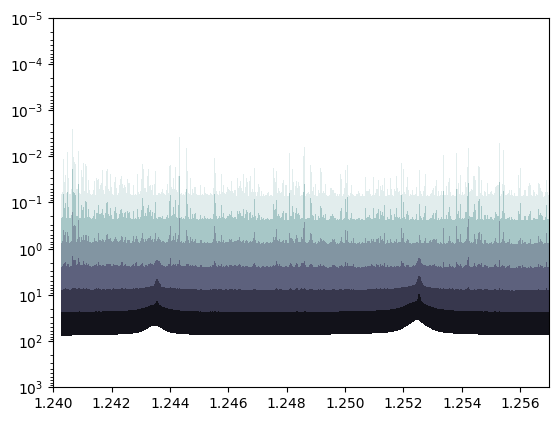

In [16]:
import petitRADTRANS.nat_cst as nc

idx_low, idx_high = 0, 6048
#idx_low, idx_high = 830, 870
X, Y = np.meshgrid(nc.c/pRT_atm.atm[0].freq[idx_low:idx_high]/1e-4, PT.pressure)
plt.contourf(
    X, Y, np.log10(pRT_atm.atm[0].total_tau[0,idx_low:idx_high,0,:].T), levels=np.arange(-5,3,1), 
    cmap=plt.cm.bone_r, vmin=-4, vmax=2
    )
#plt.contourf(X, Y, pRT_atm.atm[-3].total_tau[0,:,0,:].T, 30, cmap=plt.cm.bone_r)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.xlim(1.24,1.257)
plt.show()

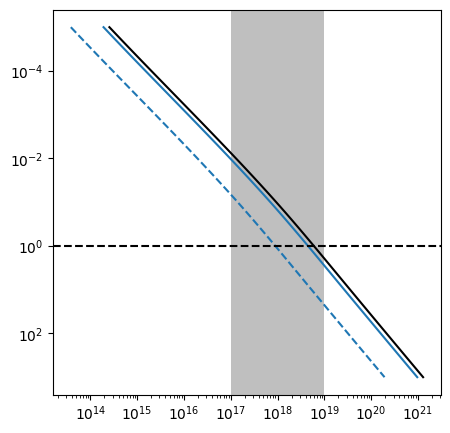

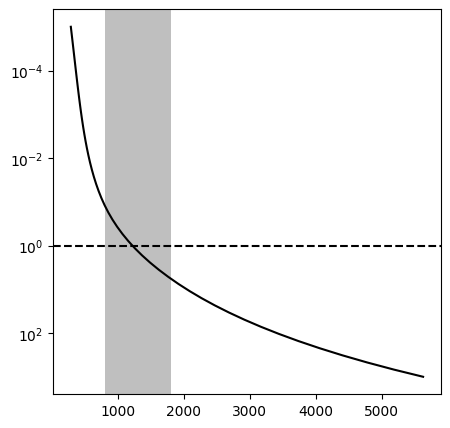

/tmp/ipykernel_185736/3397194841.py:39: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(tau_R), PT.temperature/1000, c='k')
/tmp/ipykernel_185736/3397194841.py:43: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(tau_R), np.log10(n_tot), c='k', label=r'$n_\mathrm{tot}$')
/tmp/ipykernel_185736/3397194841.py:44: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(tau_R), np.log10(n_H2), 'C0--', label=r'$n_\mathrm{H2}$')
/tmp/ipykernel_185736/3397194841.py:45: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(tau_R), np.log10(n_He), 'C0-', label=r'$n_\mathrm{He\ I}$')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2084.7632342725947
5.724895497436844e+18


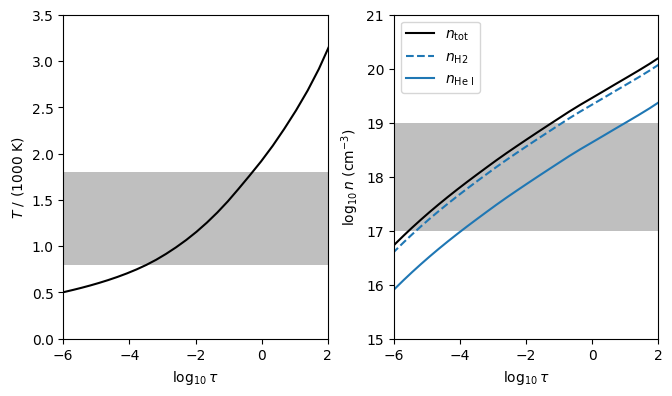

In [48]:
tau_R = np.mean(pRT_atm.atm[0].total_tau[0,:,0,:], axis=0)
#tau_R = pRT_atm.atm[-3].total_tau[0,850,0,:]
#tau_R = np.mean(pRT_atm.atm[-3].total_tau[0,800:900,0,:], axis=0)

VMR_He = 0.15
VMR_H2 = 0.75
n_tot = PT.pressure*1e6 / (nc.kB*PT.temperature)
n_He = VMR_He * n_tot
n_H2 = VMR_H2 * n_tot

plt.figure(figsize=(5,5))
plt.plot(n_tot, PT.pressure, 'k')
plt.plot(n_H2, PT.pressure, 'C0-')
plt.plot(n_He, PT.pressure, 'C0--')
plt.axhline(10**0, c='k', ls='--')
#plt.axvspan(10**17.5, 10**18.8, fc='0.75', ec='none')
plt.axvspan(10**17.0, 10**19.0, fc='0.75', ec='none')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(PT.temperature, PT.pressure, 'k')
plt.axhline(10**0, c='k', ls='--')
#plt.axvspan(1000*1,0, 1000*1.5, fc='0.75', ec='none')
plt.axvspan(1000*0.8, 1000*1.8, fc='0.75', ec='none')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.show()

print(PT.temperature[-13])
print(VMR_He * PT.pressure[-13]*1e6 / (nc.kB*PT.temperature[-13]))

fig, ax = plt.subplots(
    figsize=(7,4), ncols=2, sharex=True, 
    gridspec_kw={'wspace':0.25, 'left':0.1, 'right':0.95, 'top':0.95, 'bottom':0.14}
    )
ax[0].plot(np.log10(tau_R), PT.temperature/1000, c='k')
#ax[0].axhspan(1, 1.5, fc='0.75', ec='none')
ax[0].axhspan(0.8, 1.8, fc='0.75', ec='none')

ax[1].plot(np.log10(tau_R), np.log10(n_tot), c='k', label=r'$n_\mathrm{tot}$')
ax[1].plot(np.log10(tau_R), np.log10(n_H2), 'C0--', label=r'$n_\mathrm{H2}$')
ax[1].plot(np.log10(tau_R), np.log10(n_He), 'C0-', label=r'$n_\mathrm{He\ I}$')
#ax[1].axvline(np.log10(0.1))
#ax[1].axhspan(17.5, 18.8, fc='0.75', ec='none')
ax[1].axhspan(17.0, 19.0, fc='0.75', ec='none')
ax[1].legend()

ax[0].set(
    xlabel=r'$\log_{10}\tau$', ylim=(0,3.5), 
    ylabel=r'$T\ /\ (1000\ \mathrm{K})$'
    )
ax[1].set(
    xlim=(-6,2), xlabel=r'$\log_{10}\tau$', 
    ylim=(15,21), ylabel=r'$\log_{10}n\ \mathrm{(cm^{-3})}$'
    )
plt.savefig('./plots/temp_density_tau.eps')
plt.show()

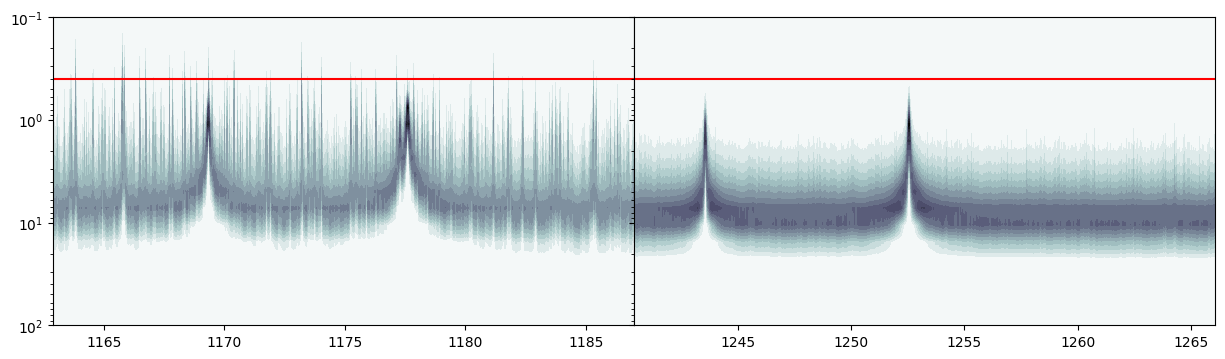

In [4]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,4), ncols=2, sharey=True, gridspec_kw={'wspace':0.0})

order = 2
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[0].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

order = 5
# Convert [cm] -> [nm]
m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

X, Y = np.meshgrid(m_wave, PT.pressure)
ax[1].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

for ax_i in ax:
    ax_i.axhline(10**(-0.4), c='r')

ax[0].set(yscale='log', ylim=(1e-1,1e2))
ax[0].invert_yaxis()

plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

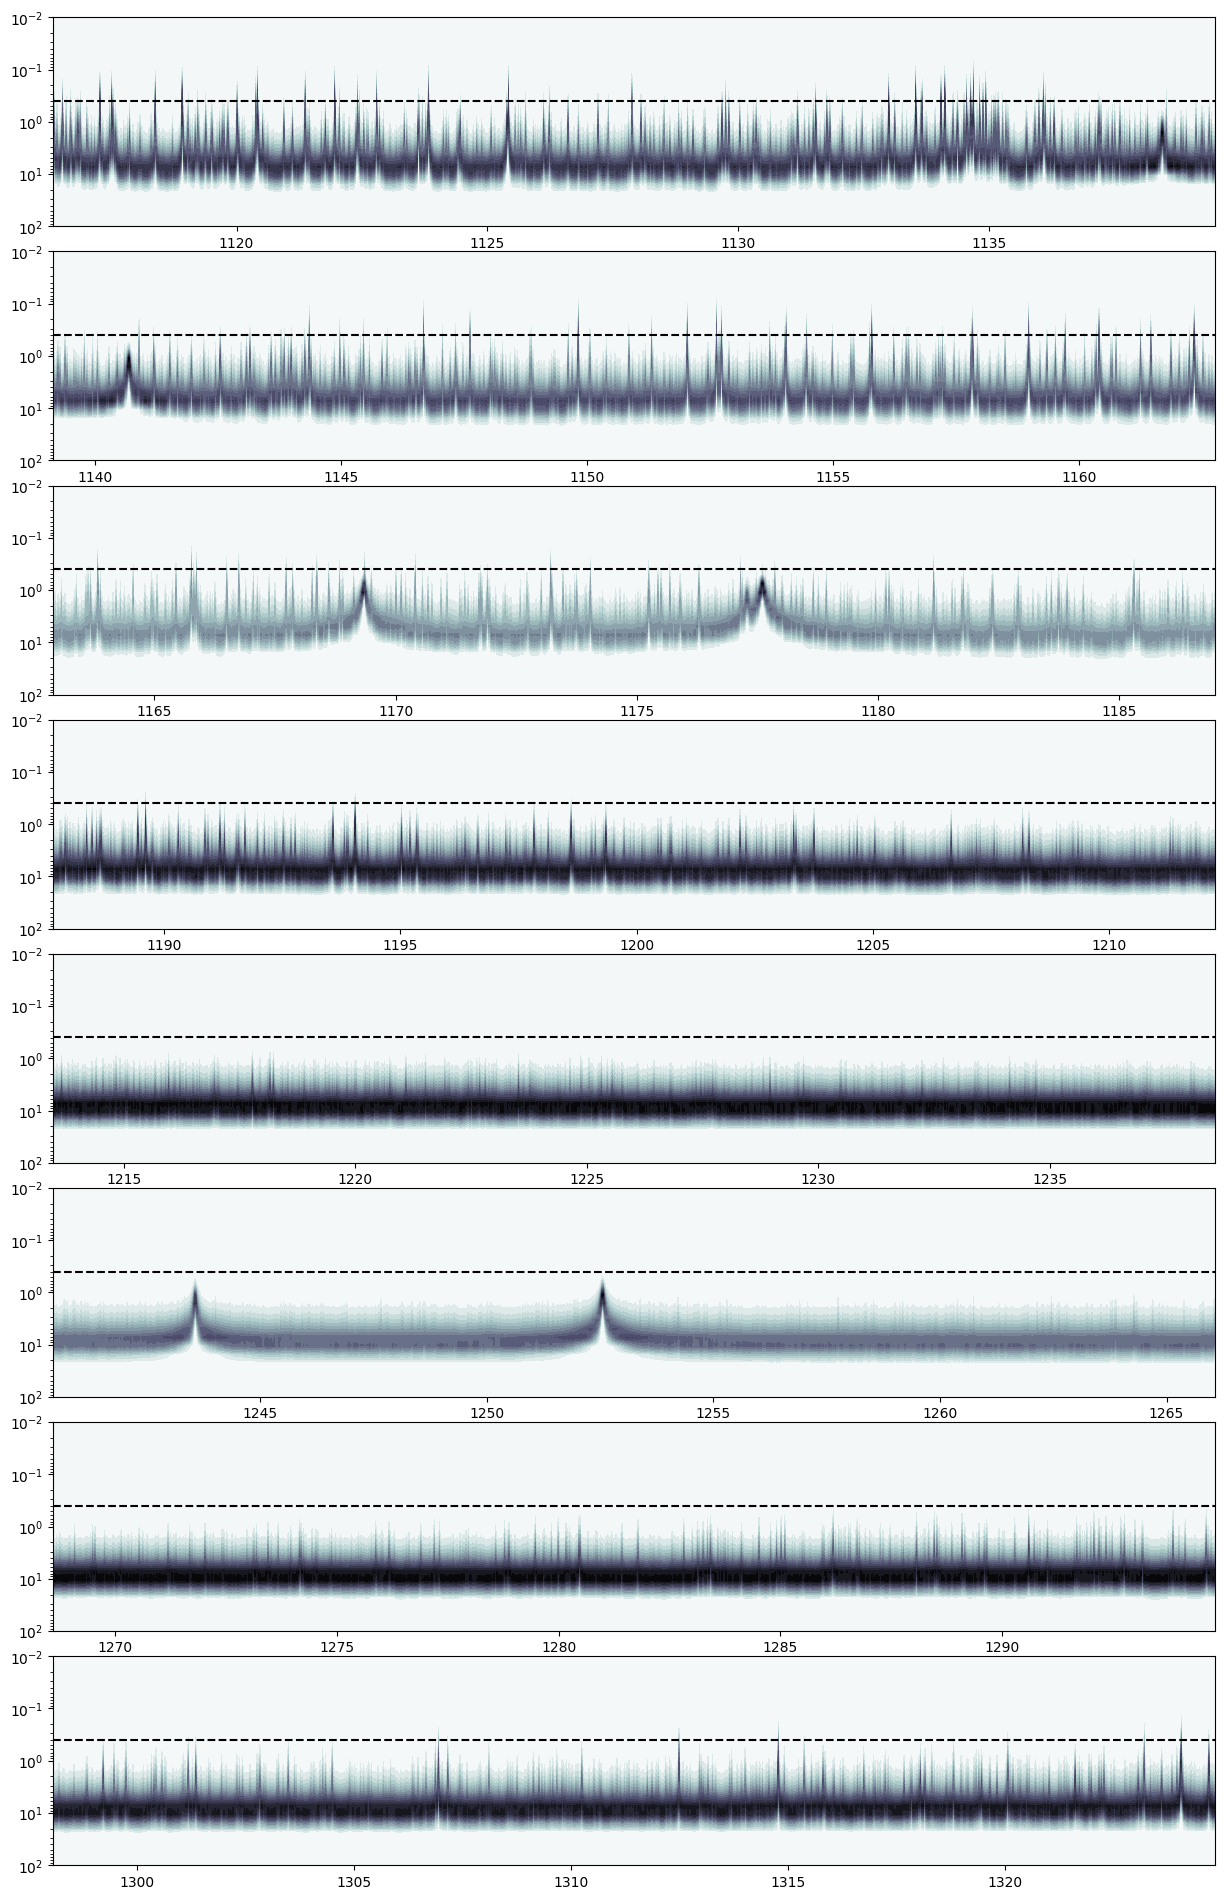

In [5]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,3*d_spec.n_orders), nrows=d_spec.n_orders, sharey=True, gridspec_kw={'hspace':0.12})

for order in range(d_spec.n_orders):
    # Convert [cm] -> [nm]
    m_wave = nc.c/pRT_atm.atm[order].freq * 1e7

    X, Y = np.meshgrid(m_wave, PT.pressure)
    ax[order].contourf(X, Y, pRT_atm.atm[order].contr_em, 15, cmap=plt.cm.bone_r)

for ax_i in ax:
    ax_i.axhline(10**(-0.4), c='k', ls='--')

ax[0].set(yscale='log', ylim=(1e-2,1e2))
ax[0].invert_yaxis()

plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

## Lorentzian fit to K I lines

[-0.05742522 -0.06069856]
[-13.8530792 -14.5377085]
[1243.59107113 1252.57483288]


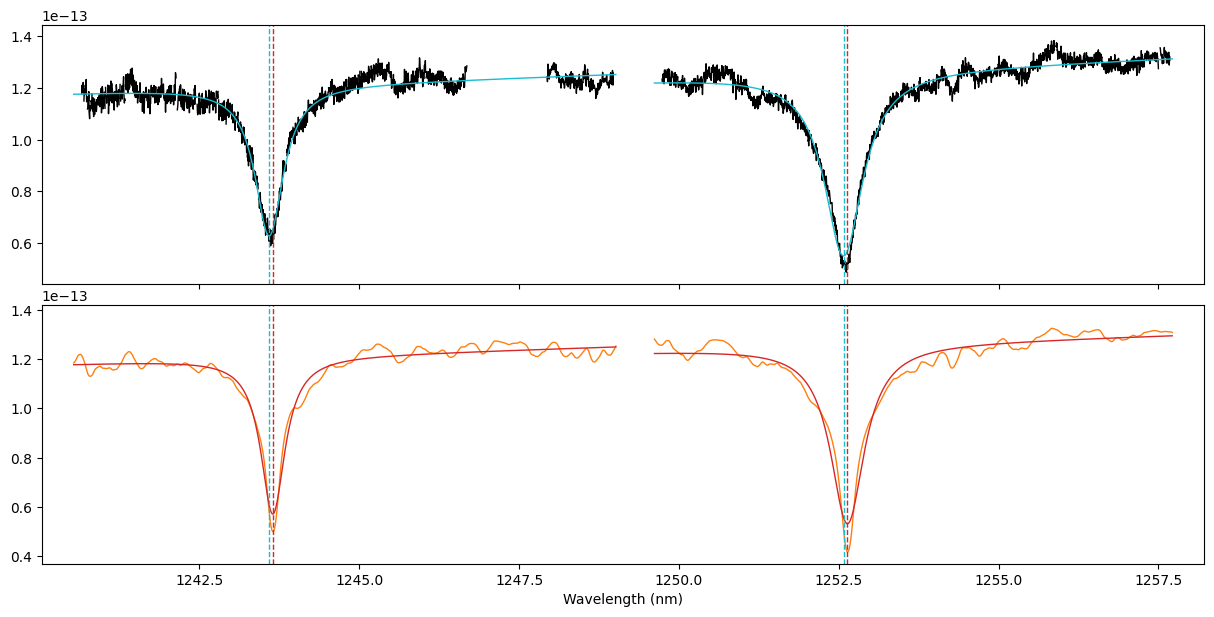

In [6]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,7), nrows=2, sharex=True, gridspec_kw={'hspace':0.08})

order = 5
for j in range(d_spec.n_dets):
    ax[0].plot(d_spec.wave[order,j], d_spec.flux[order,j], c='k', lw=1)
    ax[1].plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C1', lw=1)

from astropy.modeling.models import Lorentz1D, Linear1D, Const1D, Voigt1D
from astropy.modeling.fitting import LevMarLSQFitter

fit = LevMarLSQFitter()

s1_wave = np.arange(
    d_spec.wave[order].min()-0.5, d_spec.wave[order].max()+0.5, 
    np.diff(d_spec.wave[order].flatten())[0]
    )

s1_pRT = Lorentz1D(amplitude=-1e-13, x_0=1243.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s1_pRT = fit(
    s1_pRT, d_spec.wave[order,0], LogLike.f[order,0]*m_spec.flux[order,0]
    )
ax[1].plot(d_spec.wave[order,0], s1_pRT(d_spec.wave[order,0]), c='C3', lw=1)

s2_pRT = Lorentz1D(amplitude=-1e-13, x_0=1252.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s2_pRT = fit(
    s2_pRT, d_spec.wave[order,1], LogLike.f[order,1]*m_spec.flux[order,1]
    )
ax[1].plot(d_spec.wave[order,1], s2_pRT(d_spec.wave[order,1]), c='C3', lw=1)

########################################################################
s1_data = Lorentz1D(amplitude=-1e-13, x_0=1243.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s1_data = fit(
    s1_data, d_spec.wave[order,0][d_spec.mask_isfinite[order,0]], 
    d_spec.flux[order,0][d_spec.mask_isfinite[order,0]]
    )
ax[0].plot(d_spec.wave[order,0], s1_data(d_spec.wave[order,0]), c='C9', lw=1)

s2_data = Lorentz1D(amplitude=-1e-13, x_0=1252.6, fwhm=0.7) + \
    Linear1D(slope=1e-15, intercept=-1.1e-12) + \
    Const1D(0)
s2_data = fit(
    s2_data, d_spec.wave[order,1][d_spec.mask_isfinite[order,1]], 
    d_spec.flux[order,1][d_spec.mask_isfinite[order,1]]
    )
ax[0].plot(d_spec.wave[order,1], s2_data(d_spec.wave[order,1]), c='C9', lw=1)

K_I_pRT = np.array([s1_pRT.x_0_0.value, s2_pRT.x_0_0.value])
K_I_obs = np.array([s1_data.x_0_0.value, s2_data.x_0_0.value])

print((K_I_obs-K_I_pRT))
print((K_I_obs-K_I_pRT)/K_I_obs * 3e5)
print(K_I_obs)

for ax_i in ax:
    for line in K_I_obs:
        ax_i.axvline(line, c='C9', ls='--', lw=1)
    for line in K_I_pRT:
        ax_i.axvline(line, c='C3', ls='--', lw=1)

ax[1].set(
    xlabel=r'Wavelength (nm)', 
    xlim=(d_spec.wave[order,0].min()-0.5, d_spec.wave[order,1].max()+0.5)
    )

#plt.savefig('./plots/K_lines_fit.pdf')
plt.savefig('./plots/K_lines_fit_Luhman_16B.pdf')
plt.show()

In [8]:
data = []

1252.2141


/tmp/ipykernel_221966/3307141322.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(wave_grid[wave_blue][(flux[wave_blue] >= bins[i]) & (flux[wave_blue] < bins[i+1])])
/tmp/ipykernel_221966/3307141322.py:43: RuntimeWarning: Mean of empty slice
  np.nanmean(wave_grid[wave_red][(flux[wave_red] >= bins[i]) & (flux[wave_red] < bins[i+1])])


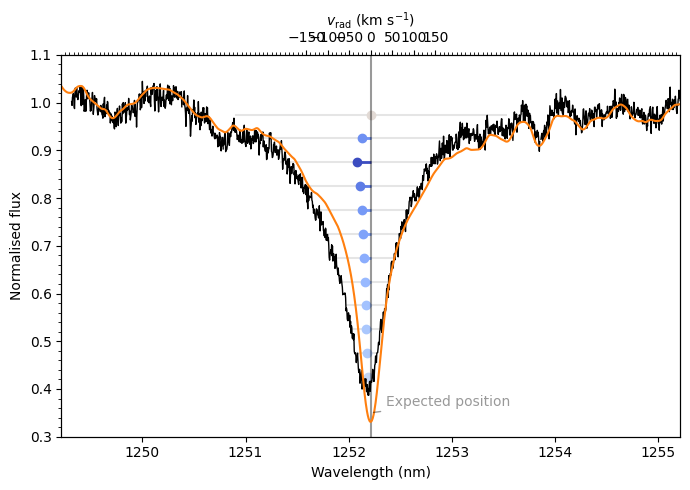

[1268.09334365 1236.72762233] [1259.22687114 1228.29288306]


In [10]:
rv = bestfit_params['params']['rv']
order = 5

det = 1

wave_grid = d_spec.wave[order,det] * (1-rv/3e5)

wave_grid /= 1.00027359

if det == 0:
    s1_data.amplitude_0 = 0
    flux = d_spec.flux[order,det] / s1_data(d_spec.wave[order,det])

    m_flux = (LogLike.f[:,:,None]*m_spec.flux)[order,det] / s1_data(d_spec.wave[order,det])

    #wave_core = 1243.64849635 # pRT location
    #wave_core = 1243.2274 * 1.00027359 # NIST location
    wave_core = 1243.2274

elif det == 1:
    s2_data.amplitude_0 = 0
    flux = d_spec.flux[order,det] / s2_data(d_spec.wave[order,det])

    m_flux = (LogLike.f[:,:,None]*m_spec.flux)[order,det] / s2_data(d_spec.wave[order,det])

    #wave_core = 1252.63553144 # pRT location
    #wave_core = 1252.2141 * 1.00027359 # NIST location
    wave_core = 1252.2141

print(wave_core)

wave_red = (wave_grid > wave_core) & (wave_grid < wave_core+1.5)
wave_blue = (wave_grid < wave_core) & (wave_grid > wave_core-1.5)

bins = np.linspace(0.3,1,15)
mean_blue = []; mean_red = []
mean_wave = []
for i in range(len(bins)-1):
    mean_blue.append(
        np.nanmean(wave_grid[wave_blue][(flux[wave_blue] >= bins[i]) & (flux[wave_blue] < bins[i+1])])
    )
    mean_red.append(
        np.nanmean(wave_grid[wave_red][(flux[wave_red] >= bins[i]) & (flux[wave_red] < bins[i+1])])
    )

    mean_wave.append(
        np.mean([mean_blue[-1],mean_red[-1]])
    )

mean_wave = np.array(mean_wave)
#print( (np.array(mean_wave) - wave_core) / wave_core * 3e5 )

fig, ax = plt.subplots(figsize=(7,5))

mean_bins = np.nanmean([bins[:-1], bins[1:]], axis=0)
ax.hlines(mean_bins, xmin=mean_blue, xmax=mean_red, colors=['k']*len(mean_bins), alpha=0.1)

cmap = plt.get_cmap('coolwarm')
colors = 0.5*(mean_wave-wave_core) / np.nanmax(np.abs(mean_wave-wave_core)) + 0.5
colors = cmap(colors)

for i in range(len(mean_wave)):
    ax.plot(mean_wave[i], mean_bins[i], marker='o', ls='', color=colors[i])
    
    if mean_wave[i] < wave_core:
        xmin = [mean_wave[i]]
        xmax = [wave_core]
    else:
        xmin = [wave_core]
        xmax = [mean_wave[i]]
    #ax.hlines([mean_bins[i]], xmin=xmin, xmax=xmax, colors=[colors[i]])
    ax.hlines([mean_bins[i]], xmin=xmin, xmax=xmax, colors=[colors[i]], lw=2)

ax.axvline(wave_core, c='k', ls='-', alpha=0.4)
#ax.axvline(wave_core-0.03, c='k', ls='-', alpha=0.4)
ax.annotate(
    'Expected position', xy=(wave_core, 0.35), xytext=(wave_core+0.15,0.08), 
    textcoords=ax.get_xaxis_transform(), color='k', alpha=0.4, 
    arrowprops={'arrowstyle':'-', 'color':'k', 'alpha':0.4}, 
    )

ax.plot(wave_grid, flux, c='k', lw=1)
ax.plot(wave_grid, m_flux, c='C1', lw=1.5)
ax.set(
    #xlim=(wave_core-1.5, wave_core+1.5), 
    xlim=(wave_core-3, wave_core+3), 
    xlabel=r'Wavelength (nm)', ylabel='Normalised flux'
    )

ax_rv = ax.twiny()
xlim = np.array(list(ax.get_xlim()))
xlim = (xlim - wave_core)/wave_core * 3e5

xticks = np.arange(-150,150+1,50)
ax_rv.set(
    ylim=(0.3,1.1), 
    xlim=xlim, xticks=xticks, 
    xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$'
)
ax_rv.minorticks_on()
fig.tight_layout()
fig.savefig(f'./plots/K_I_asymmetry_det{det}_Luhman_16B.pdf')
plt.show()

data.append([wave_grid, flux])

print(
    1e7/(1e7/wave_core+np.array([-100,100])), 
    1e7/(1e7/(1243.2274 * 1.00027359)+np.array([-100,100]))
    )

(2, 2, 2048)


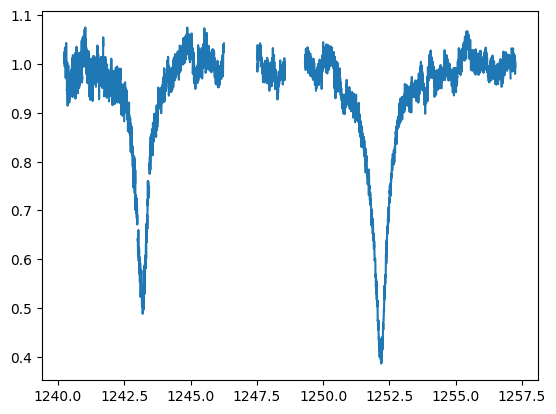

In [24]:
print(np.array(data).shape)
np.savetxt(
    './data/Luhman_16B_KI_cropped_normalized.dat', 
    np.concatenate((data[0],data[1]),axis=-1).T
    )

plt.plot(np.concatenate((data[0],data[1]),axis=-1)[0], np.concatenate((data[0],data[1]),axis=-1)[1])
plt.show()
#print(np.concatenate((data[0],data[1]),axis=-1).shape)
#print(np.flatten(np.array(data),axis=0).shape)

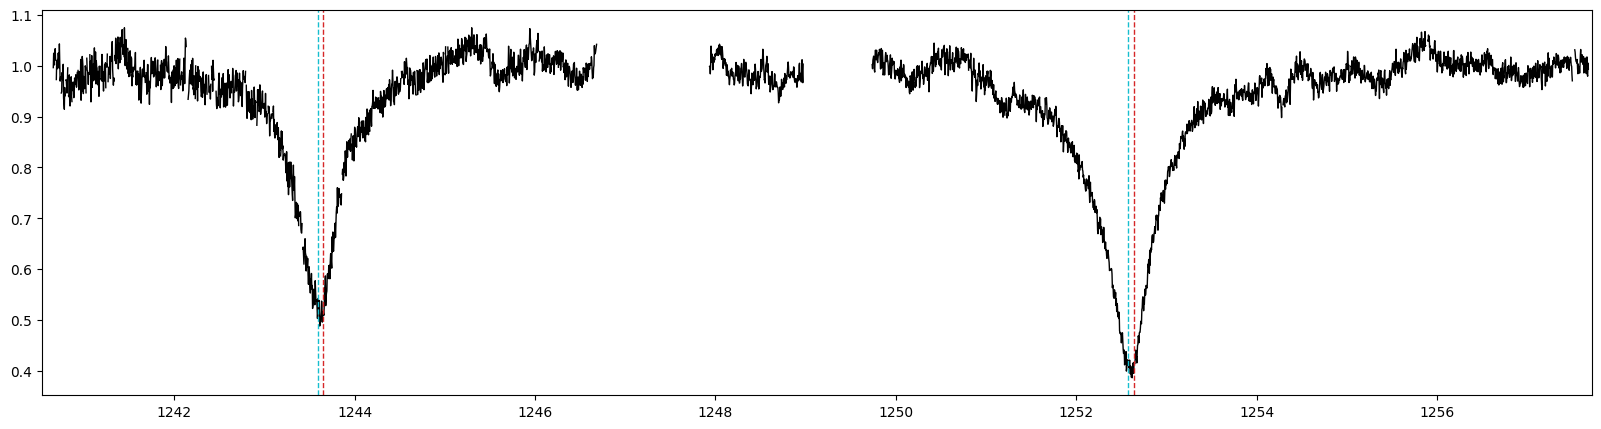

In [18]:
s1_data.amplitude_0 = 0.0
s2_data.amplitude_0 = 0.0

#fig, ax = plt.subplots(figsize=(15,5),)
plt.figure(figsize=(20,5))
plt.plot(d_spec.wave[order,0], d_spec.flux[order,0]/s1_data(d_spec.wave[order,0]), c='k', lw=1)
plt.plot(d_spec.wave[order,1], d_spec.flux[order,1]/s2_data(d_spec.wave[order,1]), c='k', lw=1)
for line in K_I_obs:
    plt.axvline(line, c='C9', ls='--', lw=1)
for line in K_I_pRT:
    plt.axvline(line, c='C3', ls='--', lw=1)
plt.xlim(d_spec.wave[order,0].min(), d_spec.wave[order,1].max())
plt.show()

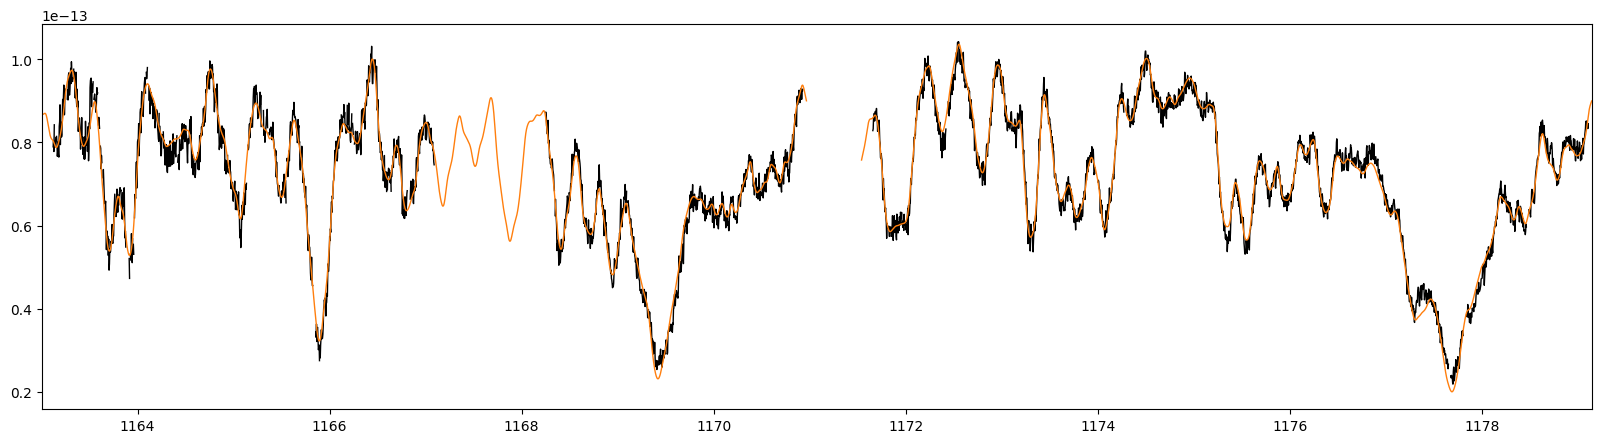

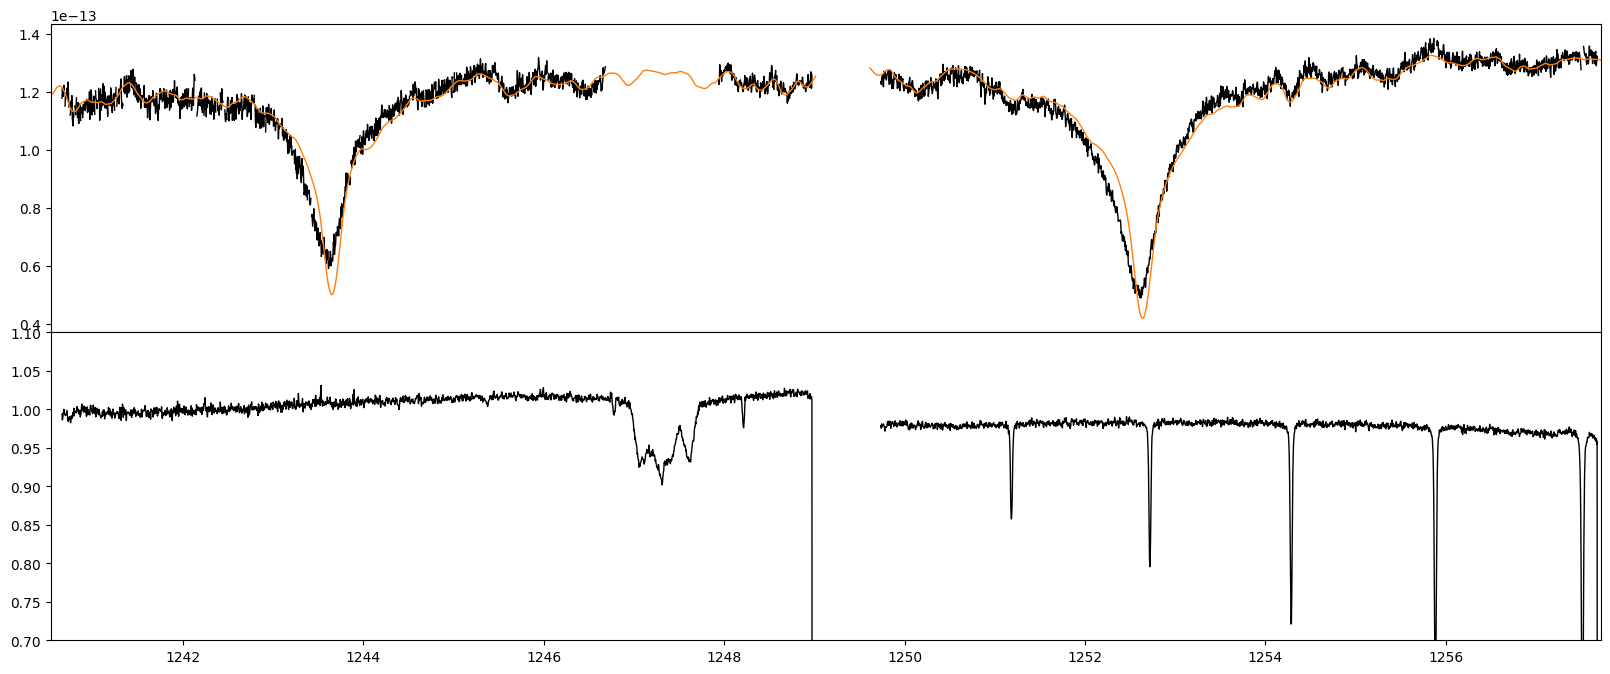

In [32]:
order = 2
plt.figure(figsize=(20,5))
plt.plot(d_spec.wave[order,0], d_spec.flux[order,0], c='k', lw=1)
plt.plot(d_spec.wave[order,1], d_spec.flux[order,1], c='k', lw=1)

plt.plot(d_spec.wave[order,0], LogLike.f[order,0]*m_spec.flux[order,0], c='C1', lw=1)
plt.plot(d_spec.wave[order,1], LogLike.f[order,1]*m_spec.flux[order,1], c='C1', lw=1)

plt.xlim(d_spec.wave[order,0].min(), d_spec.wave[order,1].max())
plt.show()

transm = np.load('./retrieval_outputs/fiducial_J_B_ret_8/test_data/d_spec_transm_J1226.npy')

order = 5
fig, ax = plt.subplots(figsize=(20,8), nrows=2, sharex=True, gridspec_kw={'hspace':0.0})
ax[0].plot(d_spec.wave[order,0], d_spec.flux[order,0], c='k', lw=1)
ax[0].plot(d_spec.wave[order,1], d_spec.flux[order,1], c='k', lw=1)

ax[0].plot(d_spec.wave[order,0], LogLike.f[order,0]*m_spec.flux[order,0], c='C1', lw=1)
ax[0].plot(d_spec.wave[order,1], LogLike.f[order,1]*m_spec.flux[order,1], c='C1', lw=1)

ax[0].set_xlim(d_spec.wave[order,0].min(), d_spec.wave[order,1].max())

ax[1].plot(d_spec.wave[order,0], transm[order,0], c='k', lw=1)
ax[1].plot(d_spec.wave[order,1], transm[order,1], c='k', lw=1)

ax[1].set_ylim(0.7,1.1)
plt.show()

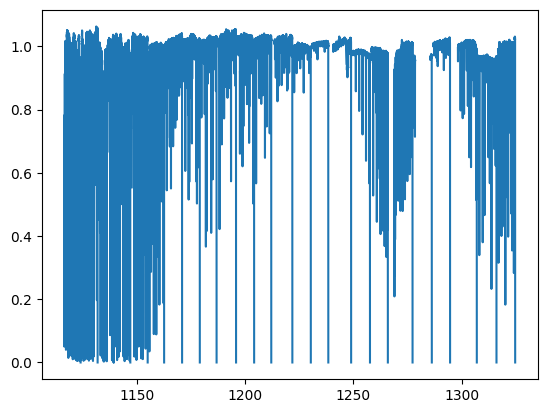

In [25]:

plt.plot(d_spec.wave.flatten(), transm.flatten())
plt.show()

## Changing potassium VMR profile

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.50664502e-07 6.50664502e-07
 6.50664502e-07 6.50664502e-07 6.50664502e-07 6.50664502e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


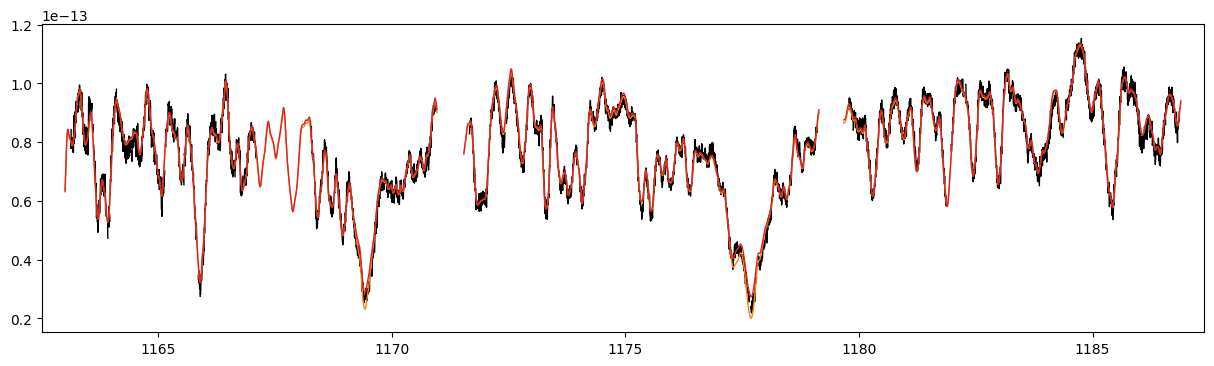

In [ ]:
import petitRADTRANS.nat_cst as nc

fig, ax = plt.subplots(figsize=(15,4), ncols=1)

Chem.mass_fractions['K'] = np.ones_like(Chem.mass_fractions['K'])*6.50664502e-07
m_spec = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

order = 2
for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], d_spec.flux[order,j], c='k', lw=1)

for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C1', lw=1)


mask_pressure = (np.log10(PT.pressure) < 0.2)
#mask_pressure = (np.log10(PT.pressure) < 0.05)
Chem.mass_fractions['K'][mask_pressure] = 0

mask_pressure = (np.log10(PT.pressure) > 1.08)
Chem.mass_fractions['K'][mask_pressure] = 0
print(Chem.mass_fractions['K'])
m_spec = pRT_atm(Chem.mass_fractions, PT.temperature, bestfit_params['params'], get_contr=True, get_full_spectrum=False)

for j in range(d_spec.n_dets):
    ax.plot(d_spec.wave[order,j], LogLike.f[order,j]*m_spec.flux[order,j], c='C3', lw=1)

ax.set(xlim=(d_spec.wave[order,0].min()-0.5, d_spec.wave[order,2].max()+0.5))

#plt.savefig('./plots/K_lines_contr_em.pdf')
plt.show()

## Equilibrium VMR profiles

0.16200790699018433


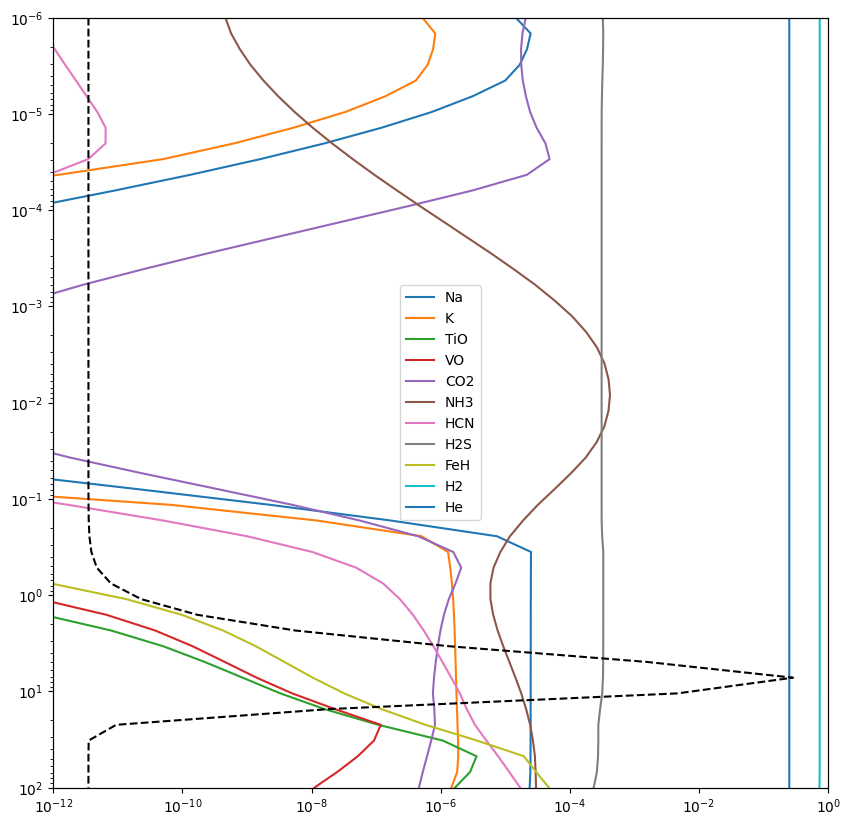

['H2',
 'He',
 'CO',
 'H2O',
 'HCN',
 'C2H2,acetylene',
 'CH4',
 'PH3',
 'CO2',
 'NH3',
 'H2S',
 'VO',
 'TiO',
 'Na',
 'K',
 'SiO',
 'e-',
 'H-',
 'H',
 'FeH',
 'MMW',
 'nabla_ad']

In [8]:
from petitRADTRANS import poor_mans_nonequ_chem as pm

pm_mass_fractions = pm.interpol_abundances(
    0.55*np.ones_like(PT.pressure), 0.0*np.ones_like(PT.pressure), 
    PT.temperature, PT.pressure
    )
print(np.mean(pm_mass_fractions['CH4']*16 + pm_mass_fractions['CO']*28 + pm_mass_fractions['H2O']*18))

fig, ax = plt.subplots(figsize=(10,10))

for species in ['Na', 'K', 'TiO', 'VO', 'CO2', 'NH3', 'HCN', 'H2S', 'FeH', 'H2', 'He']:
    ax.plot(pm_mass_fractions[species], PT.pressure, label=species)

ax.legend()
#ax.axhline(0.2, c='k', ls='--')

ax_contr = ax.twiny()
ax_contr.plot(pRT_atm.int_contr_em, PT.pressure, c='k', ls='--')
ax_contr.set(xticks=[])

ax.set(ylim=(1e-6,1e2), yscale='log', xlim=(1e-12,1e0), xscale='log')
ax.invert_yaxis()
plt.show()

list(pm_mass_fractions.keys())

## Cloud condensation

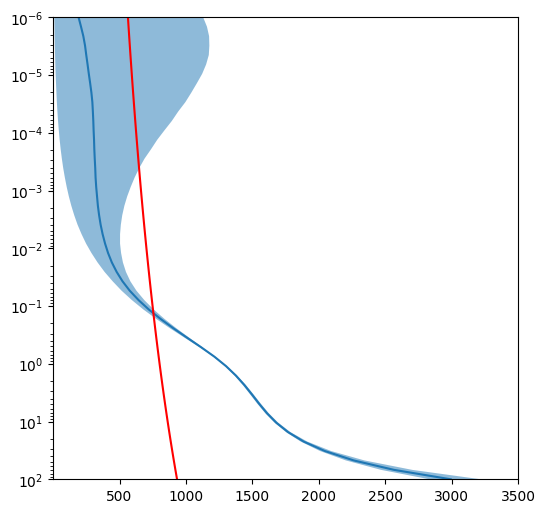

In [5]:
def cloud_condensation_curves(pressure, FeH, cloud_species):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[cloud_species]
    
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y

    return T

pressure = 10**np.linspace(-6,2,50)
T_cond = cloud_condensation_curves(pressure, 0, 'KCl')

fig, ax = plt.subplots(figsize=(6,6))
ax.fill_betweenx(pressure, PT.temperature_envelopes[1], PT.temperature_envelopes[-2], fc='C0', alpha=0.5, ec='none')
ax.plot(PT.temperature_envelopes[3], pressure, c='C0')
ax.plot(T_cond, pressure, c='r')
ax.set(yscale='log', ylim=(1e2,1e-6), xlim=(1,3500))
plt.show()